# In this notebook

#### Building binary classifier for compound activity against a target.
* Naive Bayes
* Decision Tree
* Random Forest
* LSTM RNN
* Evalutate the performance of this classifiers

#### Performance

| Classifier    | Acc | F1 |
|---------------|-----|----|
| Naive Bayes   | 0.715  | 0.722 |
| Decision Tree | 0.754  | 0.739 |
| Random Forest | 0.809  | 0.803 |
| LSTM          | 0.711  | 0.705 |


[From lecture 8 of Cheminformatics OLCC 2019](https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics_OLCC_(2019\))



### 1. Background: Cytochrome P450 (CYP2D6)
* Human CYP Enzymes few have major role in drug metabolism.
* CYP2D6 is the second most important contributor to CYP450 mediated metabolism.

In [1]:
import pandas as pd
import numpy as np
import time
import requests
from io import StringIO
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2. Downloaded data for an assay (AID 891) from PubChem.

In [2]:
# Downloading data
url = 'https://pubchem.ncbi.nlm.nih.gov/assay/pcget.cgi?query=download&record_type=datatable&actvty=all&response_type=save&aid=891'
df_raw = pd.read_csv(url)

In [3]:
df_raw.head(7)

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,...,Activity at 0.092 uM,Activity at 0.205 uM,Activity at 0.457 uM,Activity at 1.022 uM,Activity at 2.286 uM,Activity at 5.112 uM,Activity at 11.43 uM,Activity at 25.56 uM,Activity at 57.14 uM,Compound QC
0,RESULT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STRING,FLOAT,...,FLOAT,FLOAT,FLOAT,FLOAT,FLOAT,FLOAT,FLOAT,FLOAT,FLOAT,STRING
1,RESULT_DESCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indicates type of activity observed: inhibitor...,Concentration at which compound exhibits half-...,...,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,% Activity at given concentration.,"NCGC designation for data stage: 'qHTS', 'qHTS..."
2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MICROMOLAR,...,PERCENT,PERCENT,PERCENT,PERCENT,PERCENT,PERCENT,PERCENT,PERCENT,PERCENT,NaN
3,RESULT_IS_ACTIVE_CONCENTRATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RESULT_ATTR_CONC_MICROMOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0915,0.2045,0.4572,1.0224,2.286,5.1115,11.4293,25.5558,57.1429,NaN
5,1,11113142.0,6604612.0,CC[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](C3=C4C=C(C=C...,Active,99.0,NaN,NaN,Inhibitor,0.0016,...,-85.03,-86.36,-95.24,-90.27,-88.79,-89.92,NaN,-100.4,-97.15,QC'd by Timtec
6,2,11113177.0,6604463.0,CN1C[C@@H](C[C@@]2([C@@H]1CC3=CN(C4=CC=CC2=C34...,Active,99.0,NaN,NaN,Inhibitor,0.0025,...,-83.39,-86.43,-96.46,-87.64,-88.42,-91.54,NaN,-101,-98.68,QC'd by Timtec


The first 5 lines aren't needed so are dropped

In [4]:
df_raw = df_raw[5:]

### 3. Preparing data to be used for training classifiers
Checking ratio of inactive to active

In [5]:
df_raw['PUBCHEM_ACTIVITY_OUTCOME'].value_counts()

Inactive        6822
Active          1776
Inconclusive    1722
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

Removing inclonclusives

In [6]:
df = df_raw[df_raw['PUBCHEM_ACTIVITY_OUTCOME'] != 'Inconclusive']

Removing entries with no CID (CID is needed to download the SMILES from PubChem)

In [7]:
df_raw.PUBCHEM_CID.isna().sum()

24

In [8]:
df = df.dropna(subset=['PUBCHEM_CID']).copy()

Checking for duplicated CIDs with different activity classification

In [9]:
cid_conflict = []
idx_conflict = []

for mycid in df['PUBCHEM_CID'].unique() :
    
    outcomes = df[ df.PUBCHEM_CID == mycid ].PUBCHEM_ACTIVITY_OUTCOME.unique()
    
    if len(outcomes) > 1 :
        
        idx_tmp = df.index[ df.PUBCHEM_CID == mycid ].tolist()
        idx_conflict.extend(idx_tmp)
        cid_conflict.append(mycid)

print("#", len(cid_conflict), "CIDs with conflicting activities [associated with", len(idx_conflict), "rows (SIDs).]")

# 72 CIDs with conflicting activities [associated with 175 rows (SIDs).]


In [10]:
df = df.drop(idx_conflict)

Removing duplicates

In [11]:
df = df.drop_duplicates(subset='PUBCHEM_CID')  # remove duplicate rows except for the first occurring row.
df.PUBCHEM_ACTIVITY_OUTCOME.value_counts()

Inactive    6266
Active      1551
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

Adding a column with numerical values for activity

In [12]:
df['activity'] = [ 0 if x == 'Inactive' else 1 for x in df['PUBCHEM_ACTIVITY_OUTCOME'] ]

In [13]:
df.activity.value_counts()

0    6266
1    1551
Name: activity, dtype: int64

Creating dataset for building classifier

In [14]:
df_activity = df[['PUBCHEM_CID', 'activity']].copy()
actives = df_activity[df_activity.activity == 1]
inactives = df_activity[df_activity.activity == 0].sample(len(actives))
df_activity = pd.concat([actives, inactives])
df_activity.activity.value_counts()

0    1551
1    1551
Name: activity, dtype: int64

Downloading SMILES for all compounds

In [15]:
cids = df_activity.PUBCHEM_CID.astype(int).tolist()

chunk_size = 200
num_cids = len(cids)

if num_cids % chunk_size == 0 :
    num_chunks = int( num_cids / chunk_size )
else :
    num_chunks = int( num_cids / chunk_size ) + 1

print("# CIDs = ", num_cids)
print("# CID Chunks = ", num_chunks, "(chunked by ", chunk_size, ")")

import time
import requests
from io import StringIO
from tqdm import tqdm

df_smiles = pd.DataFrame()
list_dfs = []  # temporary list of data frames

for i in tqdm(range(0, num_chunks)):
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    cidstr = ",".join( str(x) for x in cids[idx1:idx2] )

    url = ('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/' + cidstr + '/property/IsomericSMILES/TXT')
    res = requests.get(url)
    data = pd.read_csv( StringIO(res.text), header=None, names=['smiles'] )
    list_dfs.append(data)
    
    time.sleep(0.2)  

#    if ( i == 2 ) : break  #- for debugging

df_smiles = pd.concat(list_dfs,ignore_index=True)
df_smiles[ 'cid' ] = cids
df_smiles.head(5)

# CIDs =  3102
# CID Chunks =  16 (chunked by  200 )


100%|███████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


,smiles,cid
0,CC[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](C3=C4C=C(C=C...,6604612
1,CN1C[C@@H](C[C@@]2([C@@H]1CC3=CN(C4=CC=CC2=C34...,6604463
2,C[C@H]1[C@H]2CN3CCC4=C([C@@H]3C[C@@H]2C(=CO1)C...,441975
3,CC(C)C1=NC(=C(C=C1)C(=O)C2=CC=CS2)SCCCCCCCCNC....,6604953
4,CC[C@@H](C(=O)OC1C[C@H]2CC[C@@H](C1)N2C)OC3=CC...,6604753


Generating fingerprints for all compounds

In [16]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [17]:
fps=dict()

for idx, row in df_smiles.iterrows() :
    
    mol = Chem.MolFromSmiles(row.smiles)
    
    if mol == None :
        print("Can't generate MOL object:", "CID", row.cid, row.smiles)
    else:
        fps[row.cid] = [row.cid] + list(MACCSkeys.GenMACCSKeys(mol).ToBitString())

In [18]:
# Generate column names
fpbitnames = []

fpbitnames.append('cid')

for i in range(0,167):   # from MACCS000 to MACCS166
    fpbitnames.append( "maccs" + str(i).zfill(3) )

df_fps = pd.DataFrame.from_dict(fps, orient='index', columns=fpbitnames)

In [19]:
df_fps.head(5)

,cid,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,maccs008,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
6604612,6604612,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
6604463,6604463,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
441975,441975,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
6604953,6604953,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6604753,6604753,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [20]:
df_activity.rename(columns = {'PUBCHEM_CID':'cid'}, inplace = True)

In [21]:
df_data = df_activity.join(df_fps.set_index('cid'), on='cid')
df_data.head()

,cid,activity,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
5,6604612.0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
6,6604463.0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
7,441975.0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
8,6604953.0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
9,6604753.0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [22]:
df_data = df_data.dropna()
len(df_data)

3102

Saving data

In [23]:
df_data.to_csv('df_data.csv')
# df_data = pd.read_csv('df_data.csv')

### 4. Training Classifiers - Data Preparation

In [24]:
X = df_data.iloc[:,2:]
y = df_data['activity'].values

In [25]:
from sklearn.feature_selection import VarianceThreshold

In [26]:
sel = VarianceThreshold()
X=sel.fit_transform(X)
X.shape  #- After removal

(3102, 160)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(2171, 160) (931, 160) (2171,) (931,)
1085 466


In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [29]:
def performance_analysis(model):
    from sklearn.metrics import f1_score
    
    y_true, y_pred = y_train, model.predict(X_train)
    CMat = confusion_matrix( y_true, y_pred )
    
    print("Using Training Data")
    print("Confusion Matrix")
    print(CMat, '\n')    # [[TN, FP],[FN, TP]]
    acc  = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    y_score = model.predict_proba(X_train)[:, 1]
    auc = roc_auc_score(y_true, y_score)
    print(f"Accuracy: {acc}\nF1 Score: {f1}\nROC AUC {auc}\n")
    
    y_true, y_pred = y_test, model.predict(X_test)
    CMat = confusion_matrix( y_true, y_pred )
    
    print("Using Test Data")
    print("Confusion Matrix")
    print(CMat, '\n')    # [[TN, FP],[FN, TP]]
    acc  = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    y_score = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_true, y_score)
    print(f"Accuracy: {acc}\nF1 Score: {f1}\nROC AUC {auc}")
    print("\n")
    print(classification_report(y_true, y_pred))

### 4.1 Training a Naive Bayes Classifier

In [30]:
from sklearn.naive_bayes import BernoulliNB

nb_clf = BernoulliNB()            # set up the NB classification model
nb_clf.fit(X_train ,y_train)    # Train the model by fitting it to the data.

performance_analysis(nb_clf)

Using Training Data
Confusion Matrix
[[722 364]
 [265 820]] 

Accuracy: 0.7102717641639797
F1 Score: 0.7227853680035258
ROC AUC 0.7854299802259168

Using Test Data
Confusion Matrix
[[321 144]
 [121 345]] 

Accuracy: 0.715359828141783
F1 Score: 0.7225130890052357
ROC AUC 0.7830818219576354


              precision    recall  f1-score   support

           0       0.73      0.69      0.71       465
           1       0.71      0.74      0.72       466

    accuracy                           0.72       931
   macro avg       0.72      0.72      0.72       931
weighted avg       0.72      0.72      0.72       931



### 4.2 Training a Simple Decision Tree Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train ,y_train)

performance_analysis(dt_clf)

Using Training Data
Confusion Matrix
[[1085    1]
 [  18 1067]] 

Accuracy: 0.9912482726853984
F1 Score: 0.9911751045053413
ROC AUC 0.9998463901689708

Using Test Data
Confusion Matrix
[[351 114]
 [126 340]] 

Accuracy: 0.7422126745435016
F1 Score: 0.7391304347826086
ROC AUC 0.7502838155890905


              precision    recall  f1-score   support

           0       0.74      0.75      0.75       465
           1       0.75      0.73      0.74       466

    accuracy                           0.74       931
   macro avg       0.74      0.74      0.74       931
weighted avg       0.74      0.74      0.74       931



Optimizing decision tree

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
scores = [ 'roc_auc', 'balanced_accuracy' ]

In [34]:
ncvs = 10

max_depth_range         = np.linspace( 3, 7, num=5, dtype='int32' )
min_samples_split_range = np.linspace( 3, 7, num=5, dtype='int32' )
min_samples_leaf_range  = np.linspace( 2, 6, num=5, dtype='int32' )

param_grid = dict( max_depth=max_depth_range,
                   min_samples_split=min_samples_split_range,
                   min_samples_leaf=min_samples_leaf_range )

clf = GridSearchCV( DecisionTreeClassifier( random_state=0 ),
                    param_grid=param_grid, cv=ncvs, scoring=scores, refit='roc_auc',
                    return_train_score = True)

In [35]:
clf.fit( X_train, y_train )
print("Best parameter set", clf.best_params_)

Best parameter set {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 3}


In [36]:
means_1a = clf.cv_results_['mean_train_roc_auc']
stds_1a  = clf.cv_results_['std_train_roc_auc']

means_1b = clf.cv_results_['mean_test_roc_auc']
stds_1b  = clf.cv_results_['std_test_roc_auc']

means_2a = clf.cv_results_['mean_train_balanced_accuracy']
stds_2a  = clf.cv_results_['std_train_balanced_accuracy']

means_2b = clf.cv_results_['mean_test_balanced_accuracy']
stds_2b  = clf.cv_results_['std_test_balanced_accuracy']

iterobjs = zip( means_1a, stds_1a, means_1b, stds_1b,
                means_2a, stds_2a, means_2b, stds_2b, clf.cv_results_['params'] )

for m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b, params in iterobjs :

    print( "Grid %r : %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f %0.4f %0.04f"
           % ( params, m1a, s1a, m1b, s1b, m2a, s2a, m2b, s2b))

Grid {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 7} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.0041 0.7149 0.0363
Grid {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5} : 0.7850 0.0036 0.7745 0.0335 0.7265 0.004

In [37]:
performance_analysis(clf)

Using Training Data
Confusion Matrix
[[947 139]
 [210 875]] 

Accuracy: 0.8392445877475817
F1 Score: 0.8337303477846593
ROC AUC 0.9065886736088127

Using Test Data
Confusion Matrix
[[378  87]
 [142 324]] 

Accuracy: 0.7540279269602578
F1 Score: 0.7388825541619156
ROC AUC 0.799937699017029


              precision    recall  f1-score   support

           0       0.73      0.81      0.77       465
           1       0.79      0.70      0.74       466

    accuracy                           0.75       931
   macro avg       0.76      0.75      0.75       931
weighted avg       0.76      0.75      0.75       931



In [38]:
%%html
<style>
table {float:left}
</style>

### 4.3 Training a Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

100%|█████████████████████████████████████████| 196/196 [03:27<00:00,  1.06s/it]


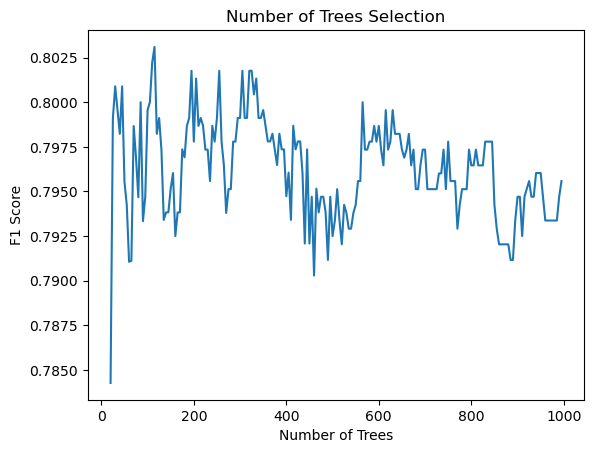

Best number of trees: 115


In [40]:
f1_scores = []
array = np.arange(20,1000,5)
for number_trees in tqdm(array):
    RFCls = RandomForestClassifier(n_estimators = number_trees, random_state = 0)
    RFCls.fit(X_train,y_train)
    f1_scores.append(f1_score(y_test, RFCls.predict(X_test)))
    
plt.plot(array, f1_scores)
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('Number of Trees Selection')
plt.show()

best_alpha = array[max(range(len(f1_scores)), key=f1_scores.__getitem__)]

print(f"Best number of trees: {best_alpha}")

In [41]:
rf_clf = RandomForestClassifier(n_estimators = best_alpha, random_state = 0)
rf_clf.fit(X_train ,y_train)

performance_analysis(rf_clf)

Using Training Data
Confusion Matrix
[[1074   12]
 [   7 1078]] 

Accuracy: 0.9912482726853984
F1 Score: 0.991264367816092
ROC AUC 0.9998166866104845

Using Test Data
Confusion Matrix
[[390  75]
 [103 363]] 

Accuracy: 0.8088077336197637
F1 Score: 0.8030973451327433
ROC AUC 0.886462227144769


              precision    recall  f1-score   support

           0       0.79      0.84      0.81       465
           1       0.83      0.78      0.80       466

    accuracy                           0.81       931
   macro avg       0.81      0.81      0.81       931
weighted avg       0.81      0.81      0.81       931



### 4.4 Using an LSTM RNN classifier

In [42]:
df_lstm = df_activity.join(df_smiles.set_index('cid'), on='cid')

In [43]:
df_lstm.head()

,cid,activity,smiles
5,6604612.0,1,CC[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](C3=C4C=C(C=C...
6,6604463.0,1,CN1C[C@@H](C[C@@]2([C@@H]1CC3=CN(C4=CC=CC2=C34...
7,441975.0,1,C[C@H]1[C@H]2CN3CCC4=C([C@@H]3C[C@@H]2C(=CO1)C...
8,6604953.0,1,CC(C)C1=NC(=C(C=C1)C(=O)C2=CC=CS2)SCCCCCCCCNC....
9,6604753.0,1,CC[C@@H](C(=O)OC1C[C@H]2CC[C@@H](C1)N2C)OC3=CC...


In [44]:
df_lstm.activity = df_lstm.activity.astype(float)

In [45]:
smiles = df_lstm.smiles.to_list()
fps = []

for smile in smiles:
    fp = list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smile)).ToBitString())
    fp = [float(x) for x in fp]
    fps.append(fp)
    
df_lstm['fingerprint'] = fps
df_lstm.head()

,cid,activity,smiles,fingerprint
5,6604612.0,1.0,CC[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](C3=C4C=C(C=C...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,6604463.0,1.0,CN1C[C@@H](C[C@@]2([C@@H]1CC3=CN(C4=CC=CC2=C34...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,441975.0,1.0,C[C@H]1[C@H]2CN3CCC4=C([C@@H]3C[C@@H]2C(=CO1)C...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,6604953.0,1.0,CC(C)C1=NC(=C(C=C1)C(=O)C2=CC=CS2)SCCCCCCCCNC....,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,6604753.0,1.0,CC[C@@H](C(=O)OC1C[C@H]2CC[C@@H](C1)N2C)OC3=CC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [46]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=2, name_length=167, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [47]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=167, embedding_dim=256)

# Step 2: Split Training and Test Data
X = np.asarray(df_lstm['fingerprint'].values.tolist())
y = np.asarray(df_lstm['activity'].values.tolist())

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                    y,
#                                                    test_size=0.2,
#                                                    random_state=0)


X_train, X_test, y_train, y_test = \
    train_test_split(X, y, shuffle=True, random_state=3100, stratify=y, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(2171, 167) (931, 167) (2171,) (931,)
1085.0 466.0


2022-10-08 13:26:23.232152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
34/34 [==============================] - 15s 389ms/step - loss: 0.6943 - accuracy: 0.4892 - val_loss: 0.6934 - val_accuracy: 0.4995
Epoch 2/40
34/34 [==============================] - 13s 392ms/step - loss: 0.6922 - accuracy: 0.5210 - val_loss: 0.6862 - val_accuracy: 0.5725
Epoch 3/40
34/34 [==============================] - 13s 379ms/step - loss: 0.6884 - accuracy: 0.5569 - val_loss: 0.6936 - val_accuracy: 0.5274
Epoch 4/40
34/34 [==============================] - 13s 392ms/step - loss: 0.6875 - accuracy: 0.5426 - val_loss: 0.6984 - val_accuracy: 0.5317
Epoch 5/40
34/34 [==============================] - 13s 388ms/step - loss: 0.6884 - accuracy: 0.5408 - val_loss: 0.6856 - val_accuracy: 0.5274
Epoch 6/40
34/34 [==============================] - 13s 398ms/step - loss: 0.6840 - accuracy: 0.5509 - val_loss: 0.6896 - val_accuracy: 0.5371
Epoch 7/40
34/34 [==============================] - 14s 402ms/step - loss: 0.6795 - accuracy: 0.5666 - val_loss: 0.6660 - val_accuracy: 0.5918

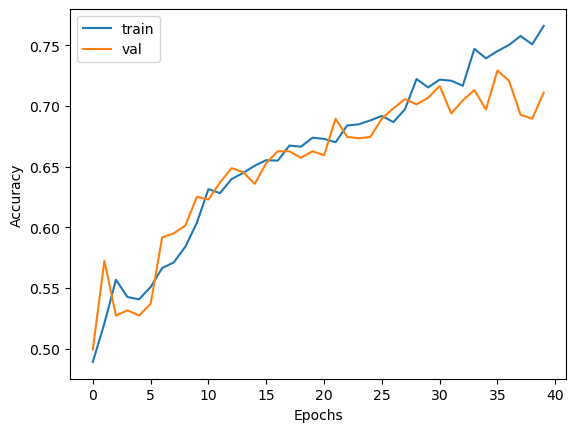

In [48]:
# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=40,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

# Step 4: Save the model
model.save('./models/activity.h5')

# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [49]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

pred_model = load_model('./models/activity.h5')

y_true, y_pred = y_train, pred_model.predict(X_train)

y_pred = [1.0 if logit > 0.5 else 0.0 for logit in y_pred]
CMat = confusion_matrix( y_true, y_pred )
    
print("Using Training Data")
print("Confusion Matrix")
print(CMat, '\n')    # [[TN, FP],[FN, TP]]
acc  = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {acc}\nF1 Score: {f1}")

y_true, y_pred = y_test, pred_model.predict(X_test)

y_pred = [1.0 if logit > 0.5 else 0.0 for logit in y_pred]
CMat = confusion_matrix( y_true, y_pred )

print("Using Test Data")
print("Confusion Matrix")
print(CMat, '\n')    # [[TN, FP],[FN, TP]]
acc  = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {acc}\nF1 Score: {f1}")
print("\n")
print(classification_report(y_true, y_pred))

68/68 [==============================] - 5s 63ms/step
Using Training Data
Confusion Matrix
[[870 216]
 [238 847]] 

Accuracy: 0.790879778903731
F1 Score: 0.7886405959031657
30/30 [==============================] - 2s 59ms/step
Using Test Data
Confusion Matrix
[[341 124]
 [145 321]] 

Accuracy: 0.7110633727175081
F1 Score: 0.7047200878155873


              precision    recall  f1-score   support

         0.0       0.70      0.73      0.72       465
         1.0       0.72      0.69      0.70       466

    accuracy                           0.71       931
   macro avg       0.71      0.71      0.71       931
weighted avg       0.71      0.71      0.71       931

